Cleaning data is a huge topic. Some people claim that data scientists spend 80% of their time just cleaning their data. The topics that we will cover here are 

* handling missing values
* removing duplicates
* structuring data
* removing outliers
* finding the right data types

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
%matplotlib inline

# Missing values

A sentinel value is used to represent missing values for numbers. A special combinations of bits represents "Not a number" (NaN). This can be thought of as the numeric equivalent of `None`. In Python `NaN` is available through the `NumPy` and `Pandas` packages. Since Pandas version 1.0, missing values are represented using a special object: `pd.NA`.

This might seems strange at first, but starts to make sense when we think about the semantics of `NaN` or more generally `NA` as a placeholder for a value that is __N__ot **A**vailable. As `NA` just represents any value that we do not know, it would be wrong to say that a value that we do not know equals another value that we do not know. Therefore `NA` can not really equal anything.

To explicitly test for `NA` we need a separate function, that is provided by `pandas`.

In [24]:
pd.isna(np.nan)

True

In [25]:
pd.isna(pd.NA)

True

In [26]:
pd.isna(42)

False

In [27]:
pd.NA == pd.NA


<NA>

In [28]:
np.nan == np.nan

False

In [29]:
pd.NA == 42, np.nan == 42

(<NA>, False)

## Handling missing values

In [30]:
ebola = pd.read_csv('data/ebola_country_timeseries.csv')
ebola

,Date,Day,Cases_Guinea,Cases_Liberia,Cases_SierraLeone,Cases_Nigeria,Cases_Senegal,Cases_UnitedStates,Cases_Spain,Cases_Mali,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone,Deaths_Nigeria,Deaths_Senegal,Deaths_UnitedStates,Deaths_Spain,Deaths_Mali
0,1/5/2015,289,2776.0,NaN,10030.0,NaN,NaN,NaN,NaN,NaN,1786.0,NaN,2977.0,NaN,NaN,NaN,NaN,NaN
1,1/4/2015,288,2775.0,NaN,9780.0,NaN,NaN,NaN,NaN,NaN,1781.0,NaN,2943.0,NaN,NaN,NaN,NaN,NaN
2,1/3/2015,287,2769.0,8166.0,9722.0,NaN,NaN,NaN,NaN,NaN,1767.0,3496.0,2915.0,NaN,NaN,NaN,NaN,NaN
3,1/2/2015,286,NaN,8157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3496.0,NaN,NaN,NaN,NaN,NaN,NaN
4,12/31/2014,284,2730.0,8115.0,9633.0,NaN,NaN,NaN,NaN,NaN,1739.0,3471.0,2827.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,3/27/2014,5,103.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,66.0,6.0,5.0,NaN,NaN,NaN,NaN,NaN
118,3/26/2014,4,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,3/25/2014,3,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,3/24/2014,2,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
ebola['Cases_Guinea'].value_counts(dropna=False).head()

NaN      29
86.0      3
112.0     2
390.0     2
495.0     2
Name: Cases_Guinea, dtype: int64

In [33]:
ebola.count()

Date                   122
Day                    122
Cases_Guinea            93
Cases_Liberia           83
Cases_SierraLeone       87
Cases_Nigeria           38
Cases_Senegal           25
Cases_UnitedStates      18
Cases_Spain             16
Cases_Mali              12
Deaths_Guinea           92
Deaths_Liberia          81
Deaths_SierraLeone      87
Deaths_Nigeria          38
Deaths_Senegal          22
Deaths_UnitedStates     18
Deaths_Spain            16
Deaths_Mali             12
dtype: int64

## Drop
The simplest way to deal with missing data is to simply drop it. However, this can lead to immense data loss, depending on how the data is organized.

In [34]:
ebola.dropna()

,Date,Day,Cases_Guinea,Cases_Liberia,Cases_SierraLeone,Cases_Nigeria,Cases_Senegal,Cases_UnitedStates,Cases_Spain,Cases_Mali,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone,Deaths_Nigeria,Deaths_Senegal,Deaths_UnitedStates,Deaths_Spain,Deaths_Mali
19,11/18/2014,241,2047.0,7082.0,6190.0,20.0,1.0,4.0,1.0,6.0,1214.0,2963.0,1267.0,8.0,0.0,1.0,0.0,6.0


In [35]:
ebola.dropna(how='all')

,Date,Day,Cases_Guinea,Cases_Liberia,Cases_SierraLeone,Cases_Nigeria,Cases_Senegal,Cases_UnitedStates,Cases_Spain,Cases_Mali,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone,Deaths_Nigeria,Deaths_Senegal,Deaths_UnitedStates,Deaths_Spain,Deaths_Mali
0,1/5/2015,289,2776.0,NaN,10030.0,NaN,NaN,NaN,NaN,NaN,1786.0,NaN,2977.0,NaN,NaN,NaN,NaN,NaN
1,1/4/2015,288,2775.0,NaN,9780.0,NaN,NaN,NaN,NaN,NaN,1781.0,NaN,2943.0,NaN,NaN,NaN,NaN,NaN
2,1/3/2015,287,2769.0,8166.0,9722.0,NaN,NaN,NaN,NaN,NaN,1767.0,3496.0,2915.0,NaN,NaN,NaN,NaN,NaN
3,1/2/2015,286,NaN,8157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3496.0,NaN,NaN,NaN,NaN,NaN,NaN
4,12/31/2014,284,2730.0,8115.0,9633.0,NaN,NaN,NaN,NaN,NaN,1739.0,3471.0,2827.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,3/27/2014,5,103.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,66.0,6.0,5.0,NaN,NaN,NaN,NaN,NaN
118,3/26/2014,4,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,3/25/2014,3,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,3/24/2014,2,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fill
Instead missing values can be filled in so the rest of the data remains useable. Keep in mind that this always introduces artifacts.

We can fill with a constant value.

In [36]:
ebola.fillna(0).head()

,Date,Day,Cases_Guinea,Cases_Liberia,Cases_SierraLeone,Cases_Nigeria,Cases_Senegal,Cases_UnitedStates,Cases_Spain,Cases_Mali,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone,Deaths_Nigeria,Deaths_Senegal,Deaths_UnitedStates,Deaths_Spain,Deaths_Mali
0,1/5/2015,289,2776.0,0.0,10030.0,0.0,0.0,0.0,0.0,0.0,1786.0,0.0,2977.0,0.0,0.0,0.0,0.0,0.0
1,1/4/2015,288,2775.0,0.0,9780.0,0.0,0.0,0.0,0.0,0.0,1781.0,0.0,2943.0,0.0,0.0,0.0,0.0,0.0
2,1/3/2015,287,2769.0,8166.0,9722.0,0.0,0.0,0.0,0.0,0.0,1767.0,3496.0,2915.0,0.0,0.0,0.0,0.0,0.0
3,1/2/2015,286,0.0,8157.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3496.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12/31/2014,284,2730.0,8115.0,9633.0,0.0,0.0,0.0,0.0,0.0,1739.0,3471.0,2827.0,0.0,0.0,0.0,0.0,0.0


Or use some more advanced strategies to impute the data, such as compute a per column mean. This can be replaced by every simple summary statistic.

In [37]:
ebola.mean()

Day                     144.778689
Cases_Guinea            911.064516
Cases_Liberia          2335.337349
Cases_SierraLeone      2427.367816
Cases_Nigeria            16.736842
Cases_Senegal             1.080000
Cases_UnitedStates        3.277778
Cases_Spain               1.000000
Cases_Mali                3.500000
Deaths_Guinea           563.239130
Deaths_Liberia         1101.209877
Deaths_SierraLeone      693.701149
Deaths_Nigeria            6.131579
Deaths_Senegal            0.000000
Deaths_UnitedStates       0.833333
Deaths_Spain              0.187500
Deaths_Mali               3.166667
dtype: float64

In [38]:
ebola.fillna(ebola.mean()).head()

,Date,Day,Cases_Guinea,Cases_Liberia,Cases_SierraLeone,Cases_Nigeria,Cases_Senegal,Cases_UnitedStates,Cases_Spain,Cases_Mali,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone,Deaths_Nigeria,Deaths_Senegal,Deaths_UnitedStates,Deaths_Spain,Deaths_Mali
0,1/5/2015,289,2776.000000,2335.337349,10030.000000,16.736842,1.08,3.277778,1.0,3.5,1786.00000,1101.209877,2977.000000,6.131579,0.0,0.833333,0.1875,3.166667
1,1/4/2015,288,2775.000000,2335.337349,9780.000000,16.736842,1.08,3.277778,1.0,3.5,1781.00000,1101.209877,2943.000000,6.131579,0.0,0.833333,0.1875,3.166667
2,1/3/2015,287,2769.000000,8166.000000,9722.000000,16.736842,1.08,3.277778,1.0,3.5,1767.00000,3496.000000,2915.000000,6.131579,0.0,0.833333,0.1875,3.166667
3,1/2/2015,286,911.064516,8157.000000,2427.367816,16.736842,1.08,3.277778,1.0,3.5,563.23913,3496.000000,693.701149,6.131579,0.0,0.833333,0.1875,3.166667
4,12/31/2014,284,2730.000000,8115.000000,9633.000000,16.736842,1.08,3.277778,1.0,3.5,1739.00000,3471.000000,2827.000000,6.131579,0.0,0.833333,0.1875,3.166667


Some more advanced techniques, such as the Expectation Maximization (EM) algorithm exist, but are not implemented in `pandas` directly. 

When dealing with serial data, it can make sense to fill missing values with previous or subsequent values. <br>
``method=='ffill'`` will fill values with the previous value in the row, while ``method=='bfill'`` does the reverse.

In [39]:
ebola.fillna(method='ffill').head()

,Date,Day,Cases_Guinea,Cases_Liberia,Cases_SierraLeone,Cases_Nigeria,Cases_Senegal,Cases_UnitedStates,Cases_Spain,Cases_Mali,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone,Deaths_Nigeria,Deaths_Senegal,Deaths_UnitedStates,Deaths_Spain,Deaths_Mali
0,1/5/2015,289,2776.0,NaN,10030.0,NaN,NaN,NaN,NaN,NaN,1786.0,NaN,2977.0,NaN,NaN,NaN,NaN,NaN
1,1/4/2015,288,2775.0,NaN,9780.0,NaN,NaN,NaN,NaN,NaN,1781.0,NaN,2943.0,NaN,NaN,NaN,NaN,NaN
2,1/3/2015,287,2769.0,8166.0,9722.0,NaN,NaN,NaN,NaN,NaN,1767.0,3496.0,2915.0,NaN,NaN,NaN,NaN,NaN
3,1/2/2015,286,2769.0,8157.0,9722.0,NaN,NaN,NaN,NaN,NaN,1767.0,3496.0,2915.0,NaN,NaN,NaN,NaN,NaN
4,12/31/2014,284,2730.0,8115.0,9633.0,NaN,NaN,NaN,NaN,NaN,1739.0,3471.0,2827.0,NaN,NaN,NaN,NaN,NaN


In [40]:
ebola.fillna(method='ffill').tail()

,Date,Day,Cases_Guinea,Cases_Liberia,Cases_SierraLeone,Cases_Nigeria,Cases_Senegal,Cases_UnitedStates,Cases_Spain,Cases_Mali,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone,Deaths_Nigeria,Deaths_Senegal,Deaths_UnitedStates,Deaths_Spain,Deaths_Mali
117,3/27/2014,5,103.0,8.0,6.0,0.0,1.0,1.0,1.0,1.0,66.0,6.0,5.0,0.0,0.0,0.0,1.0,1.0
118,3/26/2014,4,86.0,8.0,6.0,0.0,1.0,1.0,1.0,1.0,62.0,6.0,5.0,0.0,0.0,0.0,1.0,1.0
119,3/25/2014,3,86.0,8.0,6.0,0.0,1.0,1.0,1.0,1.0,60.0,6.0,5.0,0.0,0.0,0.0,1.0,1.0
120,3/24/2014,2,86.0,8.0,6.0,0.0,1.0,1.0,1.0,1.0,59.0,6.0,5.0,0.0,0.0,0.0,1.0,1.0
121,3/22/2014,0,49.0,8.0,6.0,0.0,1.0,1.0,1.0,1.0,29.0,6.0,5.0,0.0,0.0,0.0,1.0,1.0


In [41]:
ebola.fillna(method='bfill')

,Date,Day,Cases_Guinea,Cases_Liberia,Cases_SierraLeone,Cases_Nigeria,Cases_Senegal,Cases_UnitedStates,Cases_Spain,Cases_Mali,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone,Deaths_Nigeria,Deaths_Senegal,Deaths_UnitedStates,Deaths_Spain,Deaths_Mali
0,1/5/2015,289,2776.0,8166.0,10030.0,20.0,1.0,4.0,1.0,7.0,1786.0,3496.0,2977.0,8.0,0.0,1.0,0.0,6.0
1,1/4/2015,288,2775.0,8166.0,9780.0,20.0,1.0,4.0,1.0,7.0,1781.0,3496.0,2943.0,8.0,0.0,1.0,0.0,6.0
2,1/3/2015,287,2769.0,8166.0,9722.0,20.0,1.0,4.0,1.0,7.0,1767.0,3496.0,2915.0,8.0,0.0,1.0,0.0,6.0
3,1/2/2015,286,2730.0,8157.0,9633.0,20.0,1.0,4.0,1.0,7.0,1739.0,3496.0,2827.0,8.0,0.0,1.0,0.0,6.0
4,12/31/2014,284,2730.0,8115.0,9633.0,20.0,1.0,4.0,1.0,7.0,1739.0,3471.0,2827.0,8.0,0.0,1.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,3/27/2014,5,103.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,66.0,6.0,5.0,NaN,NaN,NaN,NaN,NaN
118,3/26/2014,4,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,3/25/2014,3,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,3/24/2014,2,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Advanced filling
Pandas also offers more advanced methods of filling missing values. The [interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas-dataframe-interpolate) function offers different ways of interpolating the missing values.
Some options require scipy as pandas passes them to the according scipy function.
 

In [42]:
ebola['Cases_Guinea'].head()

0    2776.0
1    2775.0
2    2769.0
3       NaN
4    2730.0
Name: Cases_Guinea, dtype: float64

In [43]:
# nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘spline’, ‘barycentric’, ‘polynomial’ will require scipy
# can be installed with pip(conda) install scipy
ebola['Cases_Guinea'].interpolate(method='quadratic').head()

0    2776.000000
1    2775.000000
2    2769.000000
3    2753.419091
4    2730.000000
Name: Cases_Guinea, dtype: float64

## Calculations with missing values
By default, `NumPy` is very strict about calculations involving `NA` values. Every operation involving `NA`s will result in `NA`. This correct in the sense that the final value of an operation such as `sum` can not be known if even a single value is unknown.

In [44]:
np.nansum([1, 2, np.nan, 3])

6.0

However, from a practical point of view this is not very useful. Therefore pandas takes the approach of gracefully ignoring `NA`s.

In [45]:
ebola['Cases_Guinea'].sum()

84729.0

This behavior can be changed if desired.

In [46]:
ebola['Cases_Guinea'].sum(skipna=False)

nan

# Removing duplicates
Duplicates can arise as part of messy data. It is important to identify them correctly and get rid of them, so they do not influence our statistics.

In [52]:
df1 = pd.DataFrame({
    'a': [1, 1, 1, 2, 2, 2],
    'b': [10, 20, 30, 40, 50, 50],
})

df1

,a,b
0,1,10
1,1,20
2,1,30
3,2,40
4,2,50
5,2,50


Check whether a row is a duplicate.

In [53]:
df1.duplicated()

0    False
1    False
2    False
3    False
4    False
5     True
dtype: bool

Drop the duplicate rows.

In [54]:
df1.drop_duplicates()

,a,b
0,1,10
1,1,20
2,1,30
3,2,40
4,2,50


Restrict duplicate search to a subset of the columns.

In [55]:
df1.duplicated(subset='a')

0    False
1     True
2     True
3    False
4     True
5     True
dtype: bool

In [56]:
df1.drop_duplicates(subset='a')

,a,b
0,1,10
3,2,40


# Removing Outliers
We will not cover the statistical methods, which are best suited for removing outliers. Thats a topic for a statistics course.
If you have chosen some criteria you can easily get rid of outliers using boolean indexing.

In [57]:
df = pd.DataFrame({'Data':np.random.normal(size=100)})
df

,Data
0,-0.255627
1,0.065730
2,0.595659
3,-0.434372
4,1.358773
...,...
95,-2.532955
96,-0.210489
97,-0.718160
98,0.240721


In [58]:
# keep only the ones that are within +1.5 to -1.5 standard deviations in the column 'Data'.
df[np.abs(df.Data-df.Data.mean()) <= (1.5*df.Data.std())]

,Data
0,-0.255627
1,0.065730
2,0.595659
3,-0.434372
4,1.358773
...,...
93,0.362554
96,-0.210489
97,-0.718160
98,0.240721


# Data Types

### Finding the right data types
Data can be expressed in several levels of measurement. You need to make sure to find the level of measurement that both semantically and computationally makes sense.

A quick detour to scales of measurement
1. **Nominal level** <br/>
   Numbers only represent categories and nothing more. <br/>
   E.g.: genders, colors<br/>
   You can compute: absolute and relative frequencies, mode   
   
1. **Ordinal level** <br/>
   The order has a meaning.<br/>
   E.g.: school-grades, music charts, answers on a likert scale <br/>
   You can additionally compute: cumulative frequencies, median, quantiles   
   
1. **Interval level** <br/>
   Same intervals should convey same meaning.<br/>
   Ratios of differences can be expressed. <br\>
   E.g.: temperature in celsius, (intelligence) tests<br/>
   You can additionally compute: mean, standard deviation   

1. **Ratio level**<br/>
   Ratios convey meaning and there is a specific 0 point.<br/>
   E.g.: mass, size, time, speed, temperature in Kelvin<br/>
   You can compute: coefficient of variation $c = \frac{s}{\bar X}$, i.e. a normalized standard variation 


## Categorical data
https://pandas.pydata.org/pandas-docs/stable/categorical.html

Using a categorical dtype has several advantages

* it keeps memory usage low
* it makes data useable for numeric modeling algorithms
* it signals to libraries that build on pandas how to treat the data
* it makes the intent clear, that only certain values are allowed in a column and how they relate to each other

The following `Series` could be perfectly represented using categories instead of strings.

In [71]:
s = pd.Series(['a','b', 'b', 'a', 'c', 'c'])
s

0    a
1    b
2    b
3    a
4    c
5    c
dtype: object

In [72]:
print(f'The string series is {s.nbytes} bytes big.')

The string series is 48 bytes big.


By specifying the `dtype` as "category" the data is automatically converted to a categorical scale.

In [73]:
s = pd.Series(['a','b', 'b', 'a', 'c', 'c'], dtype='category')
s

0    a
1    b
2    b
3    a
4    c
5    c
dtype: category
Categories (3, object): ['a', 'b', 'c']

In fact the `Series` gets much smaller already. The effect will be stronger on larger `Series`.

In [74]:
print(f'The categorical series is {s.nbytes} bytes big.')

The categorical series is 30 bytes big.


Categorical data is stored using numeric codes under the hood that map to categories.

In [75]:
s.cat.categories

Index(['a', 'b', 'c'], dtype='object')

In [77]:
s.cat.codes

0    0
1    1
2    1
3    0
4    2
5    2
dtype: int8

Using `dtype='category'` will create unordered categories by default.

In [78]:
s.cat.ordered

False

The `.cat` accessor allows changing and renaming categories.

In [79]:
s.cat.categories

Index(['a', 'b', 'c'], dtype='object')

In [80]:
s.cat.rename_categories(['x', 'y', 'z'])

0    x
1    y
2    y
3    x
4    z
5    z
dtype: category
Categories (3, object): ['x', 'y', 'z']

A categorical series can also be created from `pd.Categorical`. This allows you set the categories and the ordering explicitly.

In [81]:
pd.Categorical(['a', 'b', 'c', 'a'], categories=['b', 'c'],
                         ordered=False)

[NaN, 'b', 'c', NaN]
Categories (2, object): ['b', 'c']

The `Categorical` object can then be passed to the `Series` constructor to obtain a real `Series`.

In [82]:
cat_series = pd.Series(
    pd.Categorical(['a', 'b', 'c', 'a'], categories=['b', 'c', 'a'],
                         ordered=False)
)
cat_series

0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): ['b', 'c', 'a']

### Ordered Categories
What does it mean to have ordered categories?

In [83]:
cat_series2 = pd.Series(
    pd.Categorical(['c', 'a', 'c', 'b'], categories=['b', 'c', 'a'],
                         ordered=False)
)
cat_series2

0    c
1    a
2    c
3    b
dtype: category
Categories (3, object): ['b', 'c', 'a']

In [84]:
cat_series == cat_series2

0    False
1    False
2     True
3    False
dtype: bool

In [85]:
cat_series > cat_series2

TypeError: Unordered Categoricals can only compare equality or not

In [86]:
cat_series

0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): ['b', 'c', 'a']

In [87]:
cat_series.mode()

0    a
dtype: category
Categories (3, object): ['b', 'c', 'a']

In [88]:
cat_series.max()

TypeError: Categorical is not ordered for operation max
you can use .as_ordered() to change the Categorical to an ordered one


These semantics are lost when you pull out the atomic values. Only the `Series` is categorical, not the single entries.

In [89]:
cat_series.iloc[0], type(cat_series.iloc[0])

('a', str)

In [90]:
cat_series.iloc[0] < cat_series.iloc[1]

True

Now the same for an **ordered** cateogorical `Series`.

In [91]:
cat_ordered_series = pd.Series(
    pd.Categorical(['a', 'b', 'c', 'a'], categories=['b', 'c', 'a', 'd'],
                         ordered=True)
)
cat_ordered_series

0    a
1    b
2    c
3    a
dtype: category
Categories (4, object): ['b' < 'c' < 'a' < 'd']

In [92]:
cat_ordered_series2 = pd.Series(
    pd.Categorical(['c', 'a', 'c', 'b'], categories=['b', 'c', 'a', 'd'],
                    ordered=True)
)
cat_ordered_series2

0    c
1    a
2    c
3    b
dtype: category
Categories (4, object): ['b' < 'c' < 'a' < 'd']

In [93]:
cat_ordered_series > cat_ordered_series2

0     True
1    False
2    False
3     True
dtype: bool

In [94]:
cat_ordered_series.max()

'a'

In [95]:
cat_ordered_series == cat_ordered_series2

0    False
1    False
2     True
3    False
dtype: bool

The median does not work on the categorical Series but can be computed using the codes.

In [96]:
cat_ordered_series

0    a
1    b
2    c
3    a
dtype: category
Categories (4, object): ['b' < 'c' < 'a' < 'd']

In [97]:
cat_ordered_series.median()

TypeError: 'Categorical' does not implement reduction 'median'

In [98]:
cat_ordered_series.cat.codes.median()

1.5

If you need to cast existing data, to a categorical type and want to specify the categories and the ordering you can use `pd.CategoricalDtype` to create your own categorical datatype. It works the same way as `pd.Categorical` except that you do not pass the data. The newly created datatype can then be used in an `.astype` cast.

In [99]:
series = pd.Series(['a', 'b', 'c', 'a'])
series

0    a
1    b
2    c
3    a
dtype: object

In [101]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['b', 'c', 'a'],
                             ordered=True)
cat_type

CategoricalDtype(categories=['b', 'c', 'a'], ordered=True)

In [102]:
series.astype(cat_type)

0    a
1    b
2    c
3    a
dtype: category
Categories (3, object): ['b' < 'c' < 'a']

Now let's look at a real world dataset and some discretization techniques. The titanic dataset contains features about passengers of the tragic Titanic journey. A common introductory machine learning excercise is to predict survial of the passengers based on the features (see https://www.kaggle.com/c/titanic/data ).

In [103]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [104]:
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

We include all columns in the description as `object` columns are described differently than `numeric` columns and are excluded from the description by default.

In [105]:
titanic.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Olsen, Mr. Henry Margido",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Let's extend the port of embarkation with the full name to make things a bit more readable. We use a simple merge operation to achieve this (more on this later).

In [113]:
embarked_map = pd.DataFrame({'Embarked': ['C', 'Q', 'S'],
                             'EmbarkedLong': ['Cherbourg', 'Queenstown', 'Southampton']})
embarked_map

,Embarked,EmbarkedLong
0,C,Cherbourg
1,Q,Queenstown
2,S,Southampton


In [107]:
titanic = titanic.merge(embarked_map).sort_values(by='PassengerId')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,EmbarkedLong
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Southampton
644,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cherbourg
1,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Southampton
2,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Southampton
3,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Southampton


In [108]:
titanic.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex              object
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
EmbarkedLong     object
dtype: object

Since the `EmbarkedLong` column has only three distinct values it is naural to represent it using categories.

In [109]:
titanic['EmbarkedLong'].unique()

array(['Southampton', 'Cherbourg', 'Queenstown'], dtype=object)

In [110]:
titanic['EmbarkedLong'] = titanic['EmbarkedLong'].astype('category')
titanic['EmbarkedLong'].head()

0      Southampton
644      Cherbourg
1      Southampton
2      Southampton
3      Southampton
Name: EmbarkedLong, dtype: category
Categories (3, object): ['Cherbourg', 'Queenstown', 'Southampton']

In [111]:
titanic.dtypes

PassengerId        int64
Survived           int64
Pclass             int64
Name              object
Sex               object
Age              float64
SibSp              int64
Parch              int64
Ticket            object
Fare             float64
Cabin             object
Embarked          object
EmbarkedLong    category
dtype: object

The description for a categorical column is the same as for an `object` column.

In [112]:
titanic['EmbarkedLong'].describe()

count             889
unique              3
top       Southampton
freq              644
Name: EmbarkedLong, dtype: object

## Discretizing continuous values (Tiling)
Sometimes it makes sense to convert numeric into categorical data. For example, for some problems the exact age of a person might not matter, but only whether the person is underaged or not. This process of conversion is called tiling.

https://pandas.pydata.org/pandas-docs/stable/basics.html#discretization-and-quantiling

In [130]:
titanic['Age'].describe()

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Using `cut` we can discretize numeric values.

In [131]:
titanic['Age'].head(7)

0      22.0
644    38.0
1      26.0
2      35.0
3      35.0
812     NaN
4      54.0
Name: Age, dtype: float64

In [132]:
pd.cut(titanic['Age'], bins=3).head(7)

0        (0.34, 26.947]
644    (26.947, 53.473]
1        (0.34, 26.947]
2      (26.947, 53.473]
3      (26.947, 53.473]
812                 NaN
4        (53.473, 80.0]
Name: Age, dtype: category
Categories (3, interval[float64]): [(0.34, 26.947] < (26.947, 53.473] < (53.473, 80.0]]

By default `cut` will split the data into equally sized intervals. As this seldomly makes sense, we can set the bin edges ourself.

In [133]:
pd.cut(titanic['Age'], bins=[0, 17, 67, 80], include_lowest=True).head(7)

0      (17.0, 67.0]
644    (17.0, 67.0]
1      (17.0, 67.0]
2      (17.0, 67.0]
3      (17.0, 67.0]
812             NaN
4      (17.0, 67.0]
Name: Age, dtype: category
Categories (3, interval[float64]): [(-0.001, 17.0] < (17.0, 67.0] < (67.0, 80.0]]

In [134]:
pd.cut(titanic['Age'], bins=[0, 17, 67, 80]).value_counts()

(17, 67]    592
(0, 17]     113
(67, 80]      7
Name: Age, dtype: int64

If you set the bin edges manually, be sure to cover the whole range as values not falling into an interval will be set to NA.

In [136]:
pd.cut(titanic['Age'], 
       bins=[64, 66, 67, 80],
       labels=['child', 'grown-up', 'senior']).head(7)

0      NaN
644    NaN
1      NaN
2      NaN
3      NaN
812    NaN
4      NaN
Name: Age, dtype: category
Categories (3, object): ['child' < 'grown-up' < 'senior']

In [138]:
titanic['Age_coarse'] = pd.cut(titanic['Age'], bins=[0, 17, 67, 80], labels=['child', 'grown-up', 'senior'])
titanic['Age_coarse']

0      grown-up
644    grown-up
1      grown-up
2      grown-up
3      grown-up
         ...   
641    grown-up
642    grown-up
643         NaN
811    grown-up
888    grown-up
Name: Age_coarse, Length: 889, dtype: category
Categories (3, object): ['child' < 'grown-up' < 'senior']

A related function is `qcut`, which cuts at quantiles, meaning it will try to create n evenly sized bins

In [140]:
pd.qcut(titanic['Age'], 4).head()

0      (20.0, 28.0]
644    (28.0, 38.0]
1      (20.0, 28.0]
2      (28.0, 38.0]
3      (28.0, 38.0]
Name: Age, dtype: category
Categories (4, interval[float64]): [(0.419, 20.0] < (20.0, 28.0] < (28.0, 38.0] < (38.0, 80.0]]

## Converting to numeric data
Sometimes numeric data is srewed up somehow. `pd.to_numeric` handles these cases, automatically casting everything to the appropriate type.

In [151]:
numeric_data = pd.read_csv('data/numeric_data.csv')
numeric_data

,A,B,C
0,1,10.0,54.8
1,5,45.0,NA
2,notavailable,7.0,3.7
3,8,48.0,96.0


In [153]:
numeric_data.dtypes

A     object
B    float64
C     object
dtype: object

In [154]:
numeric_data['C'].sum()

' 54.8 NA 3.7 96.0'

In [155]:
numeric_data['B'].astype('int')

0    10
1    45
2     7
3    48
Name: B, dtype: int64

In [156]:
numeric_data['A'].astype('float')

ValueError: could not convert string to float: 'notavailable'

In [157]:
# the default is errors='raise', which raise an exception
# errors='ignore' will return the input
pd.to_numeric(numeric_data['A'], errors='ignore')

0               1
1               5
2    notavailable
3               8
Name: A, dtype: object

In [158]:
# error = 'coerce' will coerce into nan
pd.to_numeric(numeric_data['A'], errors='coerce')

0    1.0
1    5.0
2    NaN
3    8.0
Name: A, dtype: float64

In [159]:
pd.to_numeric(numeric_data['B'], errors='coerce')

0    10.0
1    45.0
2     7.0
3    48.0
Name: B, dtype: float64

In [160]:
pd.to_numeric(numeric_data['C'], errors='coerce')

0    54.8
1     NaN
2     3.7
3    96.0
Name: C, dtype: float64

to_numeric only works on series, but luckily we can `apply`!

In [161]:
numeric_data

,A,B,C
0,1,10.0,54.8
1,5,45.0,NA
2,notavailable,7.0,3.7
3,8,48.0,96.0


In [163]:
numeric_data.apply(pd.to_numeric, errors='coerce').dtypes #keyword-arguments are passed to the respective function

A    float64
B    float64
C    float64
dtype: object

In [164]:
isinstance(np.nan, float)

True

## Insertion: Plotting with Pandas

Pandas offers a few Plotting-functions, which base on matplotlib's corresponding functions and internally call these functions themselves. To alter their behaviour, you can pass it an axis to a matplotlib-object: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html

<AxesSubplot:>

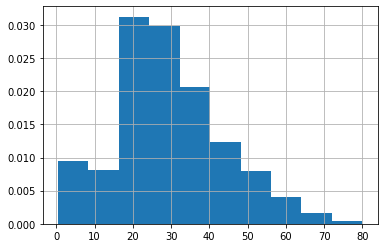

In [178]:
# density: all bars add up to one
titanic['Age'].hist(density=True)

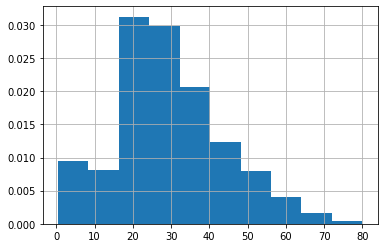

In [179]:
# the same in standard matplotlib
plt.hist(titanic['Age'].dropna().values, density=True)
plt.grid()

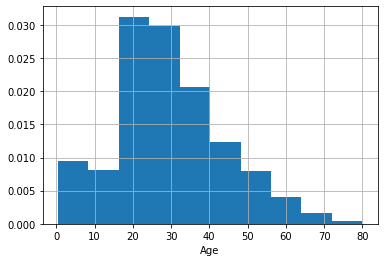

In [180]:
# use an already existing axis
fig, ax = plt.subplots()
titanic['Age'].hist(density=True, ax=ax)
ax.set_xlabel('Age');

In [181]:
titanic['Age_coarse'].value_counts()

grown-up    592
child       113
senior        7
Name: Age_coarse, dtype: int64

The [plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) function works on dataframes and series and provides a range of different plots.
By default matplotlib is used as a plotting backend.

<AxesSubplot:ylabel='Age_coarse'>

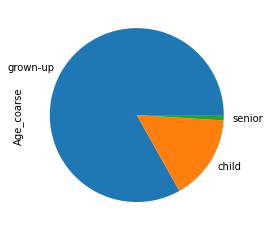

In [182]:
titanic['Age_coarse'].value_counts().plot(kind='pie')

In [183]:
coarse_age_series = titanic['Age_coarse'].cat.add_categories(['unknown'])
coarse_age_series

0      grown-up
644    grown-up
1      grown-up
2      grown-up
3      grown-up
         ...   
641    grown-up
642    grown-up
643         NaN
811    grown-up
888    grown-up
Name: Age_coarse, Length: 889, dtype: category
Categories (4, object): ['child' < 'grown-up' < 'senior' < 'unknown']

In [184]:
coarse_age_series.cat.categories

Index(['child', 'grown-up', 'senior', 'unknown'], dtype='object')

In [185]:
coarse_age_series = coarse_age_series.fillna('unknown')
coarse_age_series

0      grown-up
644    grown-up
1      grown-up
2      grown-up
3      grown-up
         ...   
641    grown-up
642    grown-up
643     unknown
811    grown-up
888    grown-up
Name: Age_coarse, Length: 889, dtype: category
Categories (4, object): ['child' < 'grown-up' < 'senior' < 'unknown']

In [186]:
coarse_age_series.value_counts()

grown-up    592
unknown     177
child       113
senior        7
Name: Age_coarse, dtype: int64

<AxesSubplot:ylabel='Age_coarse'>

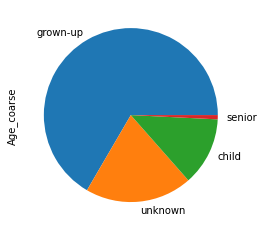

In [187]:
coarse_age_series.value_counts().plot(kind='pie')

<AxesSubplot:>

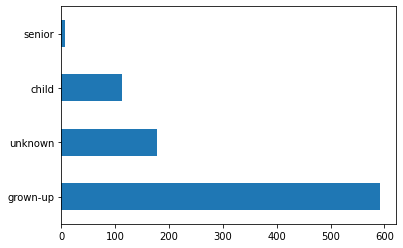

In [188]:
coarse_age_series.value_counts().plot(kind='barh')

The `plot` function also works on DataFrames.

<AxesSubplot:xlabel='Age', ylabel='Fare'>

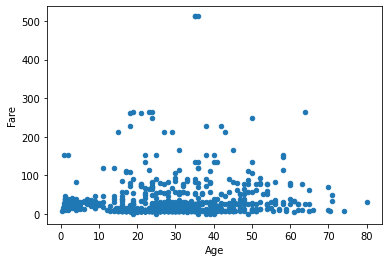

In [189]:
titanic[['Age', 'Fare']].plot(kind='scatter', x='Age', y='Fare')

# Merging DataFrames
Merging is a concept that is often used in relational databases. It allows to combine multiple tables into one by joining the columns with respect to the values in a special key column. There are different options this can be achieved.
The `DataFrame.merge` function offers these functionalities borrowed from SQL (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html#pandas-dataframe-merge).
![](pictures/merging.png)
 

In [201]:
df1 = pd.DataFrame({'A': [1, 2, 3, 4],
                    'B': [0, np.pi, 2 * np.pi, 3 * np.pi],
                    'C': ['mouse', 'cat', 'dog', 'fish']})
df1

,A,B,C
0,1,0.000000,mouse
1,2,3.141593,cat
2,3,6.283185,dog
3,4,9.424778,fish


In [202]:
df2 = pd.DataFrame({'C': ['mouse', 'horse', 'lizard', 'fish'],
                    'D': [1.0, 1.7, 3.0, 2.1],
                    'E': [1, np.e, np.e ** 2, np.e ** 3]})
df2

,C,D,E
0,mouse,1.0,1.000000
1,horse,1.7,2.718282
2,lizard,3.0,7.389056
3,fish,2.1,20.085537


## Inner Join
The inner join will take the intersection of the keys.

In [203]:
df1.merge(df2, how='inner')

,A,B,C,D,E
0,1,0.000000,mouse,1.0,1.000000
1,4,9.424778,fish,2.1,20.085537


## Left Outer Join
The left outer join will keep all values from the left table (the one on which merge is called) and use `NaN` where the right table is missing the respective rows.

In [204]:
df1.merge(df2, how='left')

,A,B,C,D,E
0,1,0.000000,mouse,1.0,1.000000
1,2,3.141593,cat,NaN,NaN
2,3,6.283185,dog,NaN,NaN
3,4,9.424778,fish,2.1,20.085537


## Right Outer Join
The right outer join works just like the left outer join but instead of using all keys from the left table, it uses all keys from the right one.

In [205]:
df1.merge(df2, how='right')

,A,B,C,D,E
0,1.0,0.000000,mouse,1.0,1.000000
1,NaN,NaN,horse,1.7,2.718282
2,NaN,NaN,lizard,3.0,7.389056
3,4.0,9.424778,fish,2.1,20.085537


## Outer Join
The outer join uses all keys that are present in both the left and the right table. Missing rows in either of the tables are filled with `NaN`.

In [206]:
df1.merge(df2, how='outer')

,A,B,C,D,E
0,1.0,0.000000,mouse,1.0,1.000000
1,2.0,3.141593,cat,NaN,NaN
2,3.0,6.283185,dog,NaN,NaN
3,4.0,9.424778,fish,2.1,20.085537
4,NaN,NaN,horse,1.7,2.718282
5,NaN,NaN,lizard,3.0,7.389056


## Overlapping column names

In [207]:
df2 = df2.rename(columns={'D': 'A'})
df2

,C,A,E
0,mouse,1.0,1.000000
1,horse,1.7,2.718282
2,lizard,3.0,7.389056
3,fish,2.1,20.085537


In [208]:
df1

,A,B,C
0,1,0.000000,mouse
1,2,3.141593,cat
2,3,6.283185,dog
3,4,9.424778,fish


If it is not implicitly clear on which column the join should occur, we have to tell Pandas which column to use. It can also perform the join on multiple columns but therefore the dtypes of the matched columns inside the two DataFrames must be equal.

In [209]:
df1.merge(df2, how='inner')

/home/nion/anaconda3/envs/pandas/lib/python3.9/site-packages/pandas/core/reshape/merge.py:1151: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,A,B,C,E
0,1,0.0,mouse,1.0


We can explicitly tell Pandas on which column the join should occur using the keyword argument `on`. The `suffixes` parameter allows us to control how overlapping column names should be changed in the joined DataFrame.

In [210]:
df1.merge(df2, how='inner', on='C', suffixes=('_from_df1', '_from_df2'))

,A_from_df1,B,C,A_from_df2,E
0,1,0.000000,mouse,1.0,1.000000
1,4,9.424778,fish,2.1,20.085537


In [211]:
# go get rid of the above warning cast the overlapping columns to the same types and specify to merge both columns
df1['A'] = df1['A'].astype(float)
df1.merge(df2, how='inner', on=['A', 'C'])

,A,B,C,E
0,1.0,0.0,mouse,1.0


# Working with timeseries data
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html  
The most fundamental building block of timeseries data in pandas is the `Timestamp`. It represents a moment in time to the precision of a nanosecond. It is complemented by `Timedelta`, which represents a stretch of time such as "one month", without being fixed to any date and `Period`, which is a combination of the two such as "June 2018". Yet `Period` needs to have a certain regularity, such as every month.


## Timestamps
Timestamps can be easily created from human readable strings using `pd.datetime`.

In [250]:
pd.to_datetime('2020-06-09')

Timestamp('2020-06-09 00:00:00')

In [251]:
pd.to_datetime('9th June 20')

Timestamp('2020-06-09 00:00:00')

In [252]:
pd.to_datetime('06.09.2020')

Timestamp('2020-06-09 00:00:00')

For non-Americans and people who think that the day should come before the month.

In [253]:
pd.to_datetime('09.06.2020', dayfirst=True)

Timestamp('2020-06-09 00:00:00')

In [254]:
pd.to_datetime('2020-06-09 14:45')

Timestamp('2020-06-09 14:45:00')

In [255]:
date = pd.to_datetime('2020-06-09 14:45:30.600700800')
date

Timestamp('2020-06-09 14:45:30.600700800')

`Timestamps` make all information available via attributes.

In [256]:
date.year

2020

In [257]:
date.month

6

In [258]:
date.day

9

In [259]:
date.second

30

In [260]:
date.microsecond

600700

In [261]:
date.nanosecond

800

Timestamps can be compared:

In [262]:
date1 = pd.to_datetime('2020-06-09 14:45')
date2 = pd.to_datetime('2020-06-09 14:46')
date1 < date2

True

When passed a Series, `to_datetime` returns a Series (with the same index), while a list-like is converted to a DatetimeIndex:

In [263]:
# NaT: Not a Time
pd.to_datetime(pd.Series(['Jul 31, 2009', '2010-01-10', None]))

0   2009-07-31
1   2010-01-10
2          NaT
dtype: datetime64[ns]

In [264]:
pd.to_datetime(['2005/11/23', '2010.12.31'])

DatetimeIndex(['2005-11-23', '2010-12-31'], dtype='datetime64[ns]', freq=None)

`Timestamps` can be formatted using a special set of symbols. All of them can be found here https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

In [265]:
date.strftime('Today is a %A in %B')

'Today is a Tuesday in June'

In [266]:
pd.to_datetime('12-11-2010 00:00', format='%d-%m-%Y %H:%M')

Timestamp('2010-11-12 00:00:00')

### DatetimeIndex

Timestamps can be used to index data.

In [268]:
index = pd.DatetimeIndex(['2021-05-17', '2021-05-24',
                          '2021-05-31', '2021-06-07',
                          '2020-06-14'])
schedule = pd.Series(['Framing Data with Pandas', 'Basic Visualization',
                      'Cleaning and Analyzing Data with Pandas', 'Advanced Visualization',
                      'Mathematical Programming'], index=index)
schedule

2021-05-17                   Framing Data with Pandas
2021-05-24                        Basic Visualization
2021-05-31    Cleaning and Analyzing Data with Pandas
2021-06-07                     Advanced Visualization
2020-06-14                   Mathematical Programming
dtype: object

In [269]:
schedule['2021-05-24':'2021-06-07']

2021-05-24                        Basic Visualization
2021-05-31    Cleaning and Analyzing Data with Pandas
2021-06-07                     Advanced Visualization
dtype: object

Just like there's NaN for numbers, there's NaT (Not-A-Time) for timestamps:

In [270]:
dt = pd.to_datetime(['2009/07/31', 'asd'], errors='coerce')
dt

DatetimeIndex(['2009-07-31', 'NaT'], dtype='datetime64[ns]', freq=None)

`isnull()` checks for missing dates in DatetimeIndex-objects (NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike):

In [271]:
dt.isnull()

array([False,  True])

## Reading timeseries data

In [302]:
!head data/ao_monthly.txt

 1950    1  -0.60310E-01
 1950    2   0.62681E+00
 1950    3  -0.81275E-02
 1950    4   0.55510E+00
 1950    5   0.71577E-01
 1950    6   0.53857E+00
 1950    7  -0.80248E+00
 1950    8  -0.85101E+00
 1950    9   0.35797E+00
 1950   10  -0.37890E+00


Read the data which is in the fixed-width formatted lines format.

In [303]:
ts = pd.read_fwf('data/ao_monthly.txt', header=None, index_col=0)
ts.head()

,1,2
0,,
1950,1,-0.060310
1950,2,0.626810
1950,3,-0.008127
1950,4,0.555100
1950,5,0.071577


This creates an integer index instead of the desired `DateTimeIndex`.

In [304]:
ts.index

Int64Index([1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950,
            ...
            2015, 2015, 2015, 2015, 2016, 2016, 2016, 2016, 2016, 2016],
           dtype='int64', name=0, length=798)

In [307]:
ts = pd.read_fwf('data/ao_monthly.txt', header=None, index_col=0,
                 parse_dates=[[0, 1]], infer_datetime_format=True)
ts.head()

,2
0_1,
1950-01-01,-0.060310
1950-02-01,0.626810
1950-03-01,-0.008127
1950-04-01,0.555100
1950-05-01,0.071577


In [308]:
ts.index

DatetimeIndex(['1950-01-01', '1950-02-01', '1950-03-01', '1950-04-01',
               '1950-05-01', '1950-06-01', '1950-07-01', '1950-08-01',
               '1950-09-01', '1950-10-01',
               ...
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01'],
              dtype='datetime64[ns]', name='0_1', length=798, freq=None)

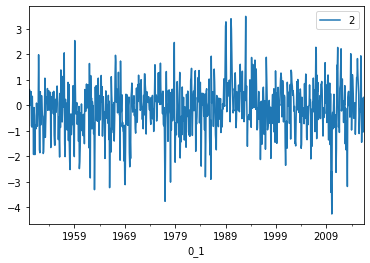

In [309]:
ts.plot();

Now that our series is indexed by timestamps, we can aggregate using time related semantics.

In [310]:
ts.index.year

Int64Index([1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950, 1950,
            ...
            2015, 2015, 2015, 2015, 2016, 2016, 2016, 2016, 2016, 2016],
           dtype='int64', name='0_1', length=798)

In [311]:
ts.groupby(ts.index.year).mean().head()

,2
0_1,
1950,-0.199501
1951,-0.364626
1952,-0.674990
1953,-0.016515
1954,-0.000770


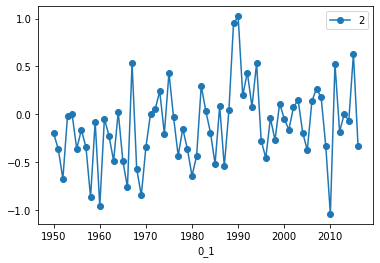

In [312]:
ts.groupby(ts.index.year).mean().plot(marker='o');

Using `pd.Grouper` we can specify more complex groupings.

In [313]:
ts.groupby(pd.Grouper(freq='5Y')).mean().head()
 

,2
0_1,
1950-12-31,-0.199501
1955-12-31,-0.283744
1960-12-31,-0.481644
1965-12-31,-0.243986
1970-12-31,-0.397825


An even easier way is to use resample.
The resample function works similar to groupby.
It will group all datetimes into buckets specified by the given [dateoffset](http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) or timedelta and will create a new dataframe after an aggregation functions is called

In [314]:
ts.resample('5Y').mean().head()

,2
0_1,
1950-12-31,-0.199501
1955-12-31,-0.283744
1960-12-31,-0.481644
1965-12-31,-0.243986
1970-12-31,-0.397825


### Resampling
If you do not like the frequency at which your data is sampled you can change the sampling frequency.

In [315]:
nineteenfifty = ts.loc['1950']
nineteenfifty.head()

,2
0_1,
1950-01-01,-0.060310
1950-02-01,0.626810
1950-03-01,-0.008127
1950-04-01,0.555100
1950-05-01,0.071577


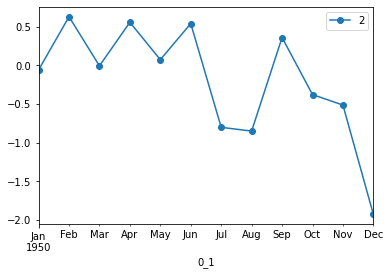

In [316]:
nineteenfifty.plot(marker='o');

In [317]:
nineteenfifty.asfreq('12D', method='ffill').head()

,2
0_1,
1950-01-01,-0.06031
1950-01-13,-0.06031
1950-01-25,-0.06031
1950-02-06,0.62681
1950-02-18,0.62681


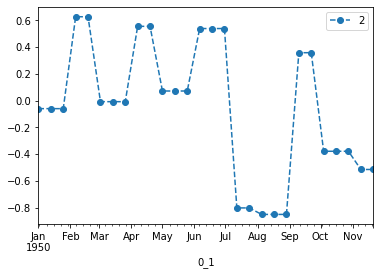

In [318]:
nineteenfifty.asfreq('12D', method='ffill').plot(style='--o');

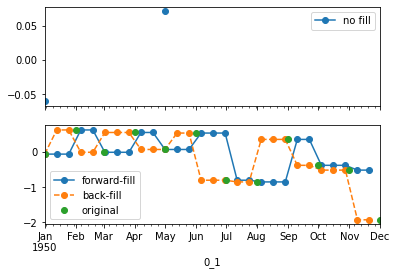

In [319]:
fig, ax = plt.subplots(nrows=2, sharex=True)

# row 1
nineteenfifty.asfreq('12D').plot(ax=ax[0], style='-o') # no fill
# row 2
nineteenfifty.asfreq('12D', method='ffill').plot(ax=ax[1], marker='o') # forward-fill
nineteenfifty.asfreq('12D', method='bfill').plot(ax=ax[1], style='--o') # back-fill
nineteenfifty.plot(ax=ax[1], style='o') # original

ax[0].legend(['no fill'])
ax[1].legend(['forward-fill', 'back-fill', 'original']);

Downsampling can be done by specifying a smaller frequency.

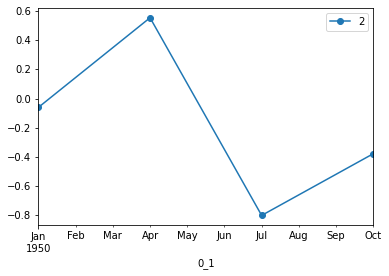

In [320]:
nineteenfifty.asfreq('3M', method='ffill').plot(marker='o');

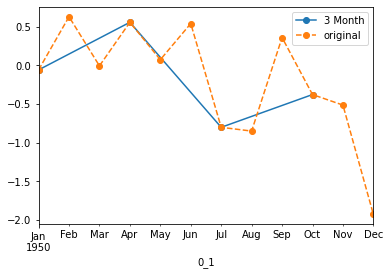

In [321]:
fig, ax = plt.subplots()

nineteenfifty.asfreq('3M', method='ffill').plot(marker='o', ax=ax) # downsampled
nineteenfifty.plot(ax=ax, style='--o') # original

ax.legend(['3 Month', 'original']);

Lets load some data and see the difference between `resample` and `asfreq`.


In [322]:
yahoo = pd.read_csv('data/yahoo_stock.csv', index_col=0, parse_dates=True)
yahoo.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,12.17,12.85,12.12,12.85,12.85,9514600
2009-01-05,12.72,13.01,12.39,12.86,12.86,11989900
2009-01-06,12.96,13.24,12.88,13.00,13.00,10056000
2009-01-07,12.71,13.16,12.45,12.71,12.71,24995900
2009-01-08,12.37,13.07,12.31,13.07,13.07,14355000


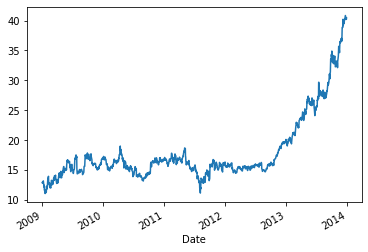

In [323]:
ts = yahoo['Close']
ts.plot();

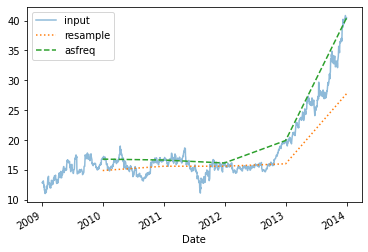

In [324]:
# 'BA' is code for business year
ts.plot(alpha=0.5, style='-')
ts.resample('BA').mean().plot(style=':')
ts.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'], loc='upper left');

### Shifting and Differencing

In [340]:
ts_resampled = ts.asfreq('D', method='ffill')

Shifting data in time can be done in two ways unsing the `shift` function. Wihtout specifying the `freq` argument shift moves the data. Creating missing values at the one end and losing data at the other. 
In contrast, we can specify the freq, which results in only a shifted index. This only works for datetime indices.

In the below example we shift the data by 365 in the second plot and the index by 365 days in the third plot.

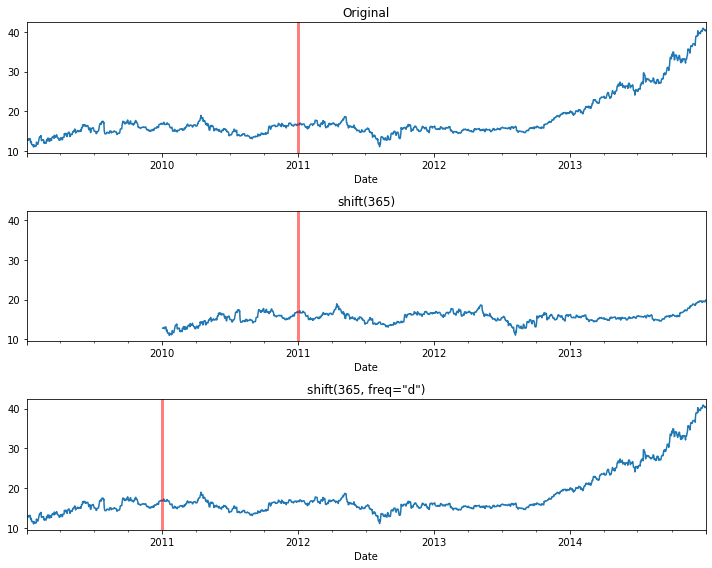

In [341]:
fig, axes = plt.subplots(nrows=3, sharey=True, figsize=(10, 8))

ts_resampled.plot(ax=axes[0], title='Original')
ts_resampled.shift(365).plot(ax=axes[1], title='shift(365)')
ts_resampled.shift(365, freq='d').plot(ax=axes[2], title='shift(365, freq="d")')

axes[0].axvline('2011', alpha=0.5, color='r', linewidth=3)
axes[1].axvline('2011', alpha=0.5, color='r', linewidth=3)
axes[2].axvline('2011', alpha=0.5, color='r', linewidth=3)

plt.tight_layout()

Shifting is useful for calculations that compare values across timesteps.  

<AxesSubplot:xlabel='Date'>

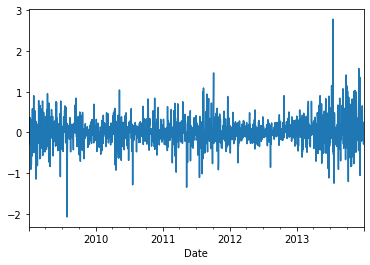

In [342]:
(ts_resampled - ts_resampled.shift(periods=1)).plot()

For differencing, pandas provides the convenient `diff` method.

<AxesSubplot:xlabel='Date'>

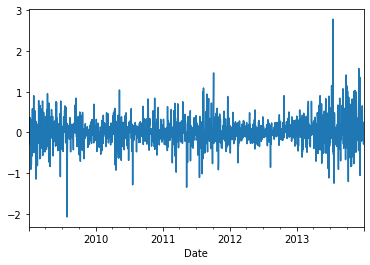

In [343]:
ts_resampled.diff(periods=1).plot()

## Window functions
Window functions are similar to `groupby` as they split data into different groups based on a changing window. The points in each window are aggregated using a summary statistic and then combined back into a timeseries.

### Rolling window
A rolling window is the standard example of a window function. It moves a window of fixed size across the timeseries.

<AxesSubplot:xlabel='Date'>

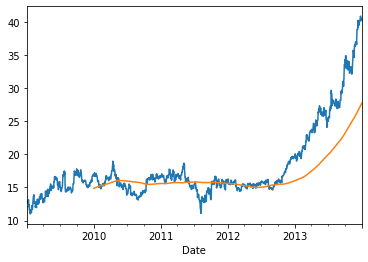

In [344]:
ts_resampled.plot()
ts_resampled.rolling(365).mean().plot()

We can also specify windows using timespans.
In this case the window is dynamicially fitted to include all Timestamps that fit into the timespan.
Therefore we do not have missing values at the beginning.

<AxesSubplot:xlabel='Date'>

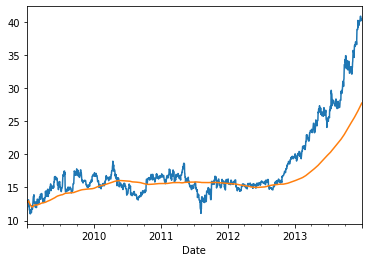

In [345]:
ts_resampled.plot()
ts_resampled.rolling('365d').mean().plot()

Setting `center=True` the point that is aggregated and put into the new series will be from the middle of the window and not from its end. 

<AxesSubplot:xlabel='Date'>

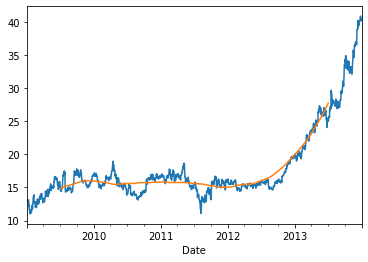

In [346]:
ts_resampled.plot()
ts_resampled.rolling(365, center=True).mean().plot()

### Expanding windows
An expanding window only has a minimal size. Then it grows bigger with each step, taking all previous values into account. This is useful if your timeseries measures a stationary value that only fluctuates around a mean.

<AxesSubplot:xlabel='Date'>

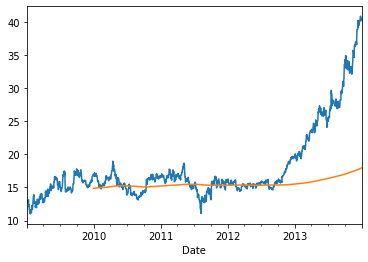

In [347]:
ts_resampled.plot()
ts_resampled.expanding(min_periods=365).mean().plot()

### Exponential weighted windows
An exponential weighted window works like an expanding window, but gives more recent datapoints an exponentially higher weighting in all calculations. Thus it can be viewed as a smooth version of a rolling window.

<AxesSubplot:xlabel='Date'>

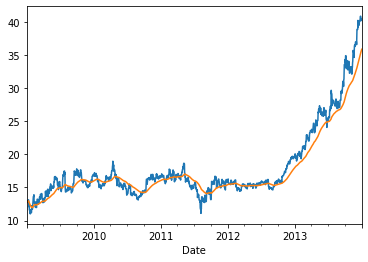

In [348]:
ts_resampled.plot()
ts_resampled.ewm(com=50.5, min_periods=5).mean().plot()

There are many more window functions.
(https://pandas.pydata.org/docs/reference/window.html)

## Optional: Timedeltas and Periods
This lecture is already quite packed again. Therefore the last to subchapter are optional. 
You can work through them if you are interested but they are not necessary for the homework.

Timedeltas can be added to Timestamps

In [ ]:
delta = pd.to_timedelta('1 day')
delta

In [ ]:
index = pd.DatetimeIndex(['2021-05-17', '2021-05-24',
                          '2021-05-31', '2021-06-07',
                          '2020-06-14'])
schedule = pd.Series(['Framing Data with Pandas', 'Basic Visualization',
                      'Cleaning and Analyzing Data with Pandas', 'Advanced Visualization',
                      'Mathematical Programming'], index=index)
schedule

In [ ]:
schedule.index += delta
schedule

In [ ]:
pd.to_datetime('2019-08-15') - pd.to_datetime('2018-06-04')

In [ ]:
schedule.index += (pd.to_datetime('2019-08-15') - pd.to_datetime('2018-06-05'))
schedule.index = schedule.index.date
schedule

The combination of Timestamps and Timedeltas allows for nice arithmetics with dates:

In [ ]:
friday = pd.Timestamp('2018-01-05')
saturday = friday + pd.to_timedelta('1 day')
saturday, saturday > friday, saturday - friday

There are even Businessdays in Pandas (Friday --> Monday)

In [ ]:
friday = pd.Timestamp('2018-01-05')
monday = friday + pd.offsets.BDay()
monday

### date_range

In [ ]:
index = pd.DatetimeIndex(['2020-06-16', '2020-06-23',
                          '2020-06-30', '2020-07-07',
                          '2020-07-14'])
schedule = pd.Series(['Statistical Visualization', 'SciPy and Statistical Modeling I',
                      'Statistical Modeling II', 'Creating Experiments',
                      'Performance Optimization'], index=index)
schedule

A more convenient way to create such an index is to use `date_range`.  
`periods` specifies how many entries we want, alternatively we could set an explicit `stop`. `freq` specifies how the entries are spaced. The full list of possible offsets can be found here http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases. Thus the syntax is very similar to `range(start, stop, step)`

In [ ]:
index = pd.date_range('2018-06-04', periods=5, freq='W')
index

Note that `freq='W'` does not mean a simple weekly frequency, but rather `the end of the week for all these dates`.

In [ ]:
index = pd.date_range('2018-06-04', periods=5, freq='7D')
index

Pandas is smart at inferring frequencies:

In [ ]:
tmp = pd.DatetimeIndex(['2018-01-01', '2018-01-03', '2018-01-05'], freq='infer')
tmp

In [ ]:
ts = pd.Series(range(len(tmp)), index=tmp)
ts

In [ ]:
ts.resample('D').sum().index

Alternatively we could use a `Period` index to signal that a topic belongs to an entire week.

In [ ]:
prd = pd.Period('2018-06-04', '7D')
prd

In [ ]:
prd.freq

In [ ]:
index = pd.period_range('2018-06-04', periods=5, freq='W')
schedule = pd.Series(['Statistical Visualization', 'SciPy and Statistical Modeling I',
                      'Statistical Modeling II', 'Creating Experiments',
                      'Performance Optimization'], index=index)
schedule

You can easily convert between `Timestamp` and period.

In [ ]:
schedule = schedule.to_timestamp()
schedule

In [ ]:
schedule.to_period(freq='W')

In [ ]:
prd

In [ ]:
prd.to_timestamp().to_period(freq='2D')

### Insertion: Accessing values in Series

In [ ]:
idx = pd.period_range('2000', periods=4)
idx

For Series and Indexes backed by normal NumPy arrays, Series.array will return a new arrays.PandasArray, which is a thin (no-copy) wrapper around a numpy.ndarray. PandasArray isn’t especially useful on its own, but it does provide the same interface as any extension array defined in pandas or by a third-party library.

In [ ]:
idx.array

In [ ]:
pd.Series([1, 2, 3]).array

In [ ]:
idx.to_numpy()

In [ ]:
type(idx.to_numpy()[0])

First info regarding anything to do with timeseries: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

Further:  
A complete time series analysis tutorial. It includes handling time zones plus basic time series prediction and classification.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('zmfe2RaX-14')

# Optional: Exploratory data analysis

Exploratory data analysis (EDA) describes the process of building up an intuition for our data. It is achieved through a combination of data transformations and visualizations. Typical steps in the process of EDA are:


1. Research the fields of the dataset 
2. Form hypotheses/develop investigation themes to explore 
3. Wrangle data 
3. Assess quality of data 
4. Profile data 
5. Explore each individual variable in the dataset 
6. Assess the relationship between each variable and the target 
7. Assess interactions between variables 
8. Explore data across many dimensions 

EDA is very important as we cannot judge whether our modeling makes sense if we don't have intuition for our data. While every analysis starts with EDA you will always return to it when you get new results from modeling.

Here we present pivot tables as an easy way to explore the relationships between variables.

## Pivot for analysis 
Last time we introduced pivot tables as a way to restructure untidy data. However, the original are an operation to create tabular summaries of data. They can be used as a convenient shortcut for a two dimensional groupby.

Let's look at a normal groupby first:

In [ ]:
titanic = pd.read_csv('data/titanic.csv')
embarked_map = pd.DataFrame({'Embarked': ['C', 'Q', 'S'],
                             'EmbarkedLong': ['Cherbourg', 'Queenstown', 'Southampton']})
embarked_map
titanic = titanic.merge(embarked_map).sort_values(by='PassengerId')
titanic

In [ ]:
titanic.groupby('Sex').mean()



Let's say we want to analyze the the influnence of gender and passenger class on survial in the titanic dataset.

In [ ]:
titanic.groupby(['Sex', 'Pclass'])['Survived'].mean()

Resetting the index makes it look a little nicer.

In [ ]:
titanic.groupby(['Sex', 'Pclass'])['Survived'].mean().reset_index()

For people being used to the tidy format, this can be read intuitively. However, you might still prefer to have the second variable in the column headers. This is what is called a "pivot table".

In [ ]:
titanic.groupby(['Sex', 'Pclass'])['Survived'].mean().unstack()

For doing exactly this, pandas provides a shortcut.

In [ ]:
titanic.pivot_table(values='Survived', index='Sex', columns='Pclass')

Pivot tables can also include the margins, i.e. the values aggregated over rows and columns.

In [ ]:
titanic.pivot_table(values='Survived', index='Sex', columns='Pclass', margins=True)

By default `pivot_table` will aggregate using the mean, but we can also choose all the functions available in `groupby` or use our own ones.

In [ ]:
titanic.pivot_table(values='Fare', index='Sex', columns='Pclass', aggfunc=[min, max])

Combining more than two variables is equally possible by stacking them in either the rows or the columns.

In [ ]:
titanic.pivot_table(values='Fare', index=['Sex', 'EmbarkedLong'], columns='Pclass',
                   aggfunc='mean')

In [ ]:
titanic['Age_coarse'] = pd.cut(titanic['Age'], bins=[0, 17, 67, 80], labels=['child', 'grown-up', 'senior'])
titanic['Age_coarse']

The tool [`pivottablejs`](https://github.com/nicolaskruchten/pivottable) allows you qickly explore data with pivotables using drag'n'drop. When using such a graphical tool you should make sure that you turn the interesting things into code so they don't get lost after closing the notebook.

In [ ]:
# pip install pivottablejs
from pivottablejs import pivot_ui
pivot_ui(titanic)

## Profiling
When doing exploratory data analysis, a lot of tasks have to be done every time so they can be automated. Tools like [pandas_profiling](https://github.com/pandas-profiling/pandas-profiling) can create summeries that give insights into many standard questions you can ask to a dataset. However, with abstraction comes less flexibility so tools like this will always only do part of your work and might at times not at all do what you want.

In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(titanic)

The following tutorial talks more about tools and processes in exploratory data analysis.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('W5WE9Db2RLU')